In [112]:
import obspy
import instaseis
import matplotlib.pyplot as plt
import numpy as np
import mpld3
from scipy.signal import hilbert
#mpld3.enable_notebook()
%matplotlib inline

### Read data

312.0


Text(0.5,0,'time (s)')

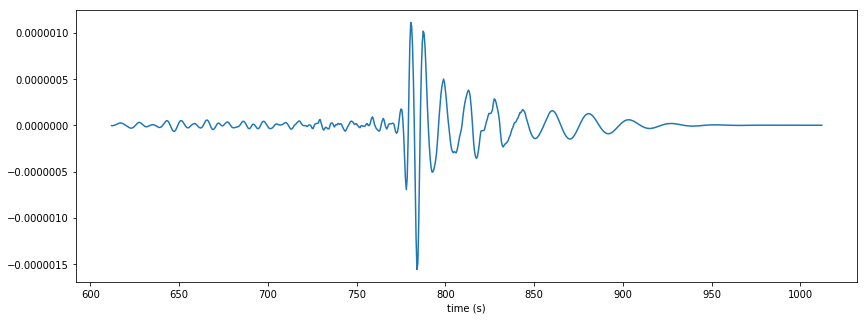

In [113]:
st = obspy.read("../data/test_sac_data/B00101Z00.sac")
r_start = st[0].stats.starttime
r_start = r_start.minute*60.0 + r_start.second
print r_start
t_0 = 300.0
t_1 = 700.0
tr = st[0].trim(starttime=st[0].stats.starttime+t_0,endtime=st[0].stats.starttime+t_1)
dist_km = tr.stats.sac['dist']
time = np.linspace(r_start+t_0,r_start+t_1,len(tr.data))
veloc = dist_km / time
fig = plt.figure(figsize=(14,5))
plt.plot(time,st[0].data)
plt.xlabel('time (s)')

Text(0.5,0,'frequency (Hz)')

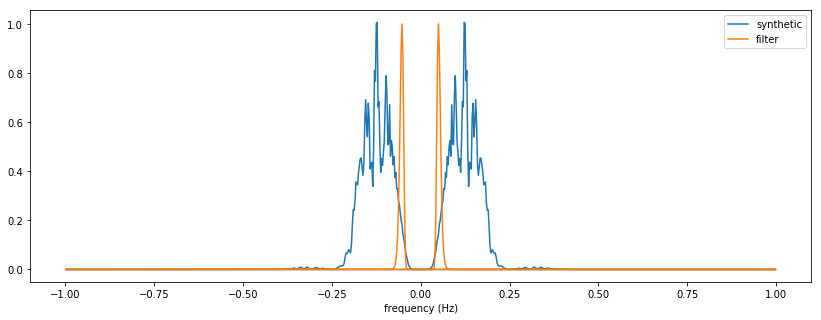

In [114]:
F_data = np.fft.fft(st[0].data)
freqs = np.fft.fftfreq(len(st[0].data),d = st[0].stats.delta)
F_filter = np.zeros(len(F_data))
alpha=50.0
period=20.0
omega_0 = 1/period
for i in range(0,len(freqs)):
    if freqs[i] > 0.0:
        fact = -alpha*((freqs[i]-omega_0)/(freqs[i]))**2
        F_filter[i] = np.exp(fact)

nfreqs = len(freqs)
fig = plt.figure(figsize=(14,5))
plt.plot(freqs,np.abs(F_data**2)/np.abs(np.max(F_data**2)),label='synthetic')
F_filter[int(nfreqs/2):] = F_filter[::-1][int(nfreqs/2):]
plt.plot(freqs,F_filter,label='filter')
plt.legend()
plt.xlabel('frequency (Hz)')

#plt.xlim([0,0.5])

Text(0.5,0,'time (s)')

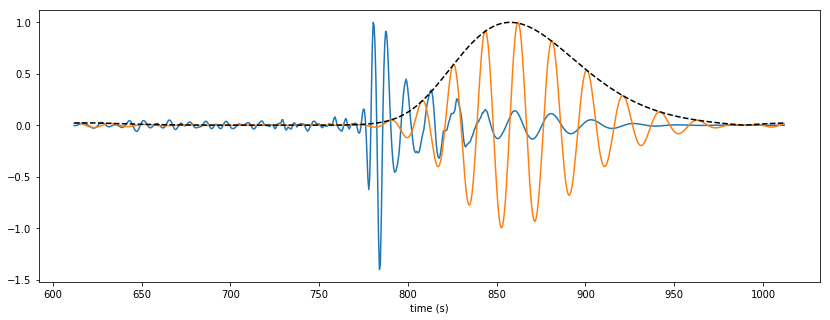

In [116]:
F_filtered = F_data * F_filter
filtered_data = np.fft.ifft(F_filtered)
fig = plt.figure(figsize=(14,5))
ansig = hilbert(filtered_data.real)
env = np.abs(ansig)

plt.plot(time,st[0].data/np.max(st[0].data))
plt.plot(time,filtered_data/np.max(filtered_data))
plt.plot(time,env/np.max(env),c='k',linestyle='--')
plt.xlabel('time (s)')

In [117]:
def gauss_filter(data,sampling_rate,w_0,alpha):
    F_data = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data),d = 1/sampling_rate)
    F_filter = np.zeros(len(F_data))
    for i in range(0,len(freqs)):
        if freqs[i] > 0.0:
            fact = -alpha*((freqs[i]-w_0)/(freqs[i]))**2
            F_filter[i] = np.exp(fact)
    nfreqs = len(freqs)
    F_filter[int(nfreqs/2):] = F_filter[::-1][int(nfreqs/2):]
    F_filtered = F_filter * F_data
    data_filtered = np.fft.ifft(F_filtered)
    return data_filtered

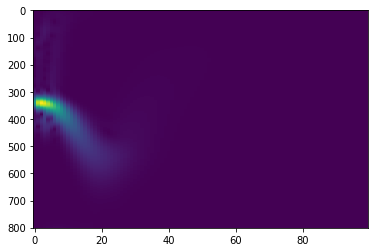

In [125]:
plt.imshow(gabor_matrix,aspect='auto')
plt.show()

/home/romaguir/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  


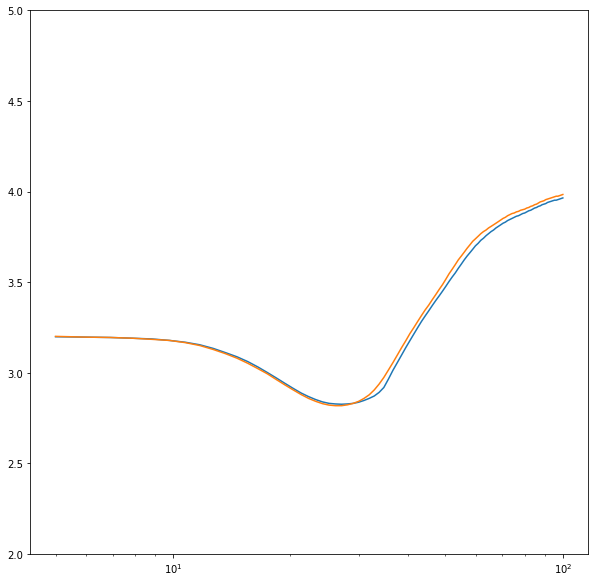

In [149]:
fig,ax = plt.subplots(1,figsize=[10,10])
periods = np.linspace(5.0,100.0,100.0)
gabor_matrix = np.zeros((len(time),len(periods)))
env_max_vel2 = []
env_max_per2 = []
for i,period in enumerate(periods):
    drow = gauss_filter(st[0].data,st[0].stats.sampling_rate,w_0=1/period,alpha=50.)
    env = np.abs(hilbert(drow.real))
    
    if np.max(env) > 0.0:
        env_max_per2.append(period)
        env_max_vel2.append(veloc[np.argmax(env)])
    
    gabor_matrix[:,i] = env
    #plt.plot(time,env,c='k',alpha=0.5)
    #gabor_matrix[:,i] = gauss_filter(st[0].data,st[0].stats.sampling_rate,w_0=1/period,alpha=50.0)
#ax.imshow(gabor_matrix,aspect='auto',cmap='jet',extent=[periods[0],periods[-1],veloc[-1],veloc[0]])
#ax.set_xlim([0,20])
#ax.set_ylim([1400,600])
#plt.scatter(env_max_per,env_max_vel)
plt.semilogx(env_max_per,env_max_vel)
plt.semilogx(env_max_per2,env_max_vel2)
plt.ylim([2,5])
plt.show()

In [144]:
np.savetxt('halfspace_grp_dispersion.txt',np.c_[env_max_per2,env_max_vel2],fmt='%5f')